In [1]:
import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.size": 13,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

import s3dexp.db
import s3dexp.db.utils as dbutils
import s3dexp.db.models as models

from utils import get_by_expnames, pretty

## App Throughput vs CPU cores
Trying to find the "kink" in the curves.

In [2]:
dataset = 'jpeg/flickr50k'
ext = 'jpg'
hostname='cloudlet029'
cpu_exp = '-cores'
bw_exp = 'mbps'

df_all = pd.read_sql(
    'SELECT expname, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers FROM EurekaExp \
        WHERE basedir LIKE %s AND hostname=%s AND (expname LIKE %s OR expname LIKE %s)',
    s3dexp.db.engine,
    params=["%{}%".format(dataset), hostname, "%{}".format(cpu_exp), "%{}".format(bw_exp)])

df_all

,expname,avg_wall_ms,throughput,num_workers
0,smart_redness-sorted-2-cores,2.820590,354.535718,2
1,smart_redness-sorted-4-cores,1.450360,689.484172,4
2,smart_redness-sorted-8-cores,0.788677,1267.946474,8
3,smart_redness-sorted-16-cores,0.725071,1379.175268,16
4,smart_hash-sorted-2-cores,2.494959,400.808177,2
5,smart_hash-sorted-4-cores,1.299520,769.515087,4
6,smart_hash-sorted-8-cores,0.743786,1344.472353,8
7,smart_hash-sorted-16-cores,0.725539,1378.285777,16
8,smart_face-sorted-2-cores,33.335862,29.997724,2
9,smart_face-sorted-4-cores,33.334290,29.999139,4


In [3]:
workloads = ['redness', 'hash', 'resnet10', 'face']
markers = ['o', '^', 's', 'x']

<IPython.core.display.Javascript object>


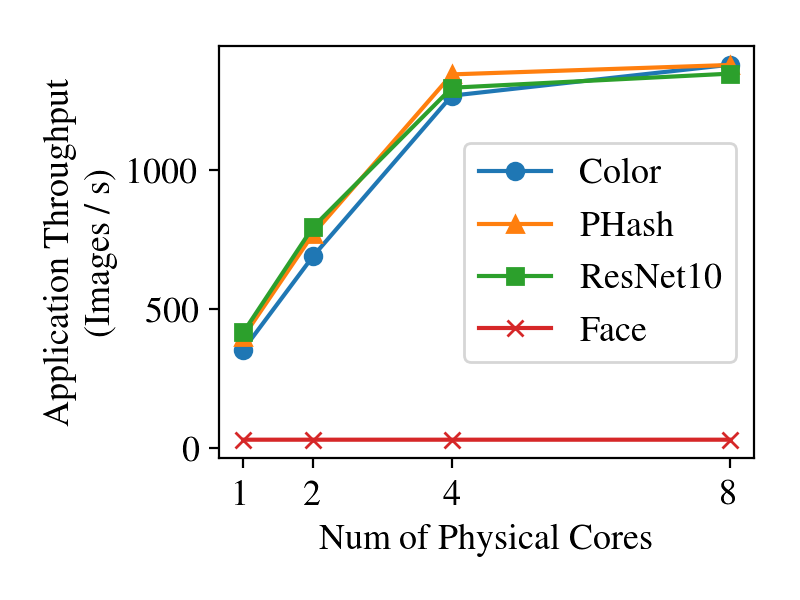

/home/zf/miniconda2/envs/s3dexp/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [4]:
%matplotlib notebook

# (logical) cpu cores
cores = np.array([2, 4, 8, 16])

plt.figure(figsize=(4,3))

for workload, m in zip(workloads, markers):
    expnames = map(lambda c: 'smart_{}-sorted-{}-cores'.format(workload, c), cores)
    df = get_by_expnames(df_all, expnames)
    plt.plot(cores/2, df['throughput'], '-'+m, label=pretty(workload))   # workers = 2 * physical cores
    
plt.xticks(cores/2)
plt.xlabel('Num of Physical Cores')
plt.ylabel('Application Throughput\n(Images / s)')
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('tput-vs-core.pdf', bbox_inches='tight')

## App Throughput vs. (Emulated) Bus Bandwidth 

In [5]:
num_workers = 4  # TODO: use 8 cores
df_all = pd.read_sql(
    'SELECT expname, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers FROM EurekaExp \
        WHERE basedir LIKE %s AND hostname=%s AND (expname LIKE %s OR expname LIKE %s) AND num_workers=%s',
    s3dexp.db.engine,
    params=["%{}%".format(dataset), hostname, "%{}".format(cpu_exp), "%{}".format(bw_exp), num_workers])

print(df_all)

                           expname  avg_wall_ms  throughput  num_workers
0     smart_redness-sorted-4-cores     1.450360  689.484172            4
1        smart_hash-sorted-4-cores     1.299520  769.515087            4
2        smart_face-sorted-4-cores    33.334290   29.999139            4
3     smart_redness-sorted-250mbps     4.245424  235.547713            4
4        smart_hash-sorted-250mbps     4.224496  236.714656            4
5        smart_face-sorted-250mbps    33.334341   29.999093            4
6     smart_redness-sorted-300mbps     3.592622  278.348268            4
7        smart_hash-sorted-300mbps     3.566721  280.369575            4
8        smart_face-sorted-300mbps    33.334377   29.999061            4
9    smart_redness-sorted-1000mbps     1.691054  591.347158            4
10      smart_hash-sorted-1000mbps     1.570949  636.558046            4
11      smart_face-sorted-1000mbps    33.334206   29.999214            4
12   smart_redness-sorted-2000mbps     1.458865  68

<IPython.core.display.Javascript object>


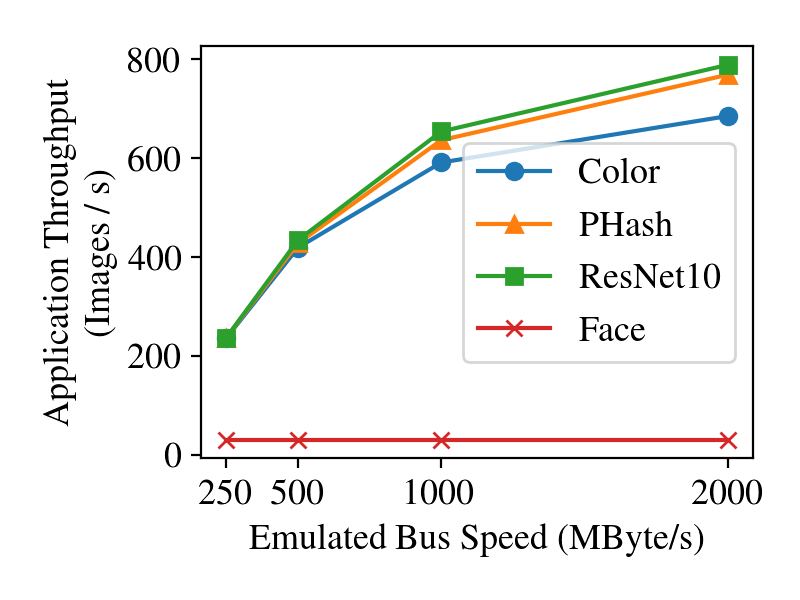

In [10]:
# Bus Bandwidth
bws = np.array([250, 500, 1000, 2000])

# throughputs = []
# for workload in workloads:             
             
#     df = throughput_bws(workload, bws)

#     throughputs.append(df)
#     width = .35
#     print(df)

# fig, axes = plt.subplots(4, figsize=(5,6), sharex=True)

# for i, w in enumerate(['Color', 'PHash', 'Resnet10', 'Face']):
#     axes[i].plot(bws, throughputs[i], 'o-', color='orange')
#     axes[i].set_xticks(bws, minor=True)
#     axes[i].title.set_text(w)
#     axes[i].set_ylabel('Throughput', fontsize=10)

# plt.tight_layout()
# plt.xlabel("Bus Bandwidth")
# plt.show()


plt.figure(figsize=(4,3))

for workload, m in zip(workloads, markers):
    expnames = map(lambda bw: 'smart_{}-sorted-{}mbps'.format(workload, bw), bws)
    df = get_by_expnames(df_all, expnames)
    plt.plot(bws, df['throughput'], '-'+m, label=pretty(workload))
    
plt.xticks(bws)
plt.xlabel('Emulated Bus Speed (MByte/s)')
plt.ylabel('Application Throughput\n(Images / s)')
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('tput-vs-bw.pdf', bbox_inches='tight')